In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from catboost import CatBoostClassifier, Pool

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv("features/emotion_features.csv")
df.head()


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-592.51970,55.269863,-19.240614,14.985034,-4.303793,-0.782968,-15.683035,-4.746463,-22.302803,-5.347614,...,-6.584931,-2.434462,-3.743652,-0.299833,1.267962,5.327147,3.982636,8.654726,11.515517,neutral
1,-571.77120,53.821240,-19.770304,14.672212,-3.221300,-2.219379,-15.660700,-4.115021,-21.762812,-0.923149,...,-6.433335,-2.461543,-4.143042,0.553830,1.998689,5.020371,4.224607,9.785756,11.845788,neutral
2,-579.21670,54.232810,-15.242693,17.250660,-4.751228,0.021345,-13.251750,-5.477705,-20.139534,-4.198607,...,-5.051621,-1.963996,-3.542640,-0.745385,1.221582,3.439566,5.602417,9.031712,9.748875,neutral
3,-581.09064,53.249720,-19.030127,17.035284,-5.648746,1.875090,-16.216503,-5.108720,-21.046432,-2.953222,...,-5.261818,-2.072452,-4.843049,0.880779,1.297034,4.160462,5.900162,9.407315,10.992938,neutral
4,-592.52057,61.175182,-16.242025,16.972326,-1.740968,-0.389398,-15.755614,-1.111939,-19.680891,-3.488038,...,2.623967,3.312066,-4.676119,-4.766972,-4.045164,1.991833,5.520200,10.280448,11.302134,calm


In [3]:
X = df.drop("label", axis=1)
y = df["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))

Training samples: 1961
Validation samples: 491


In [4]:
# Feature Selection: Keep top 30 best features
# selector = SelectKBest(score_func=f_classif, k=30)
# X_selected = selector.fit_transform(X, y)

# Split dataset
# X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# print("Training samples:", len(X_train))
# print("Validation samples:", len(X_val))

In [5]:
# ➤ Train RandomForest with tuned params
# model = RandomForestClassifier(
    # n_estimators=300,
    # max_depth=15,
    # min_samples_split=5,
    # class_weight='balanced',
    # random_state=42
# )
# model.fit(X_train, y_train)

# ➤ Predict
# y_pred = model.predict(X_val)

In [6]:
# # ➤ Metrics
# overall_accuracy = accuracy_score(y_val, y_pred)
# overall_f1 = f1_score(y_val, y_pred, average='weighted')

# print(f"✅ Overall Accuracy: {overall_accuracy * 100:.2f}%")
# print(f"✅ Weighted F1 Score: {overall_f1 * 100:.2f}%")

# # ➤ Confusion Matrix
# cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
# plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap='Blues')
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

# # ➤ Per-Class Accuracy
# report = classification_report(y_val, y_pred, output_dict=True)
# print("Per-Class Accuracies:")
# for label in model.classes_:
#     class_acc = report[label]["recall"] * 100
#     print(f"{label}: {class_acc:.2f}% accuracy")


In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model trained!")

Model trained!


Overall Accuracy: 71.28%
Weighted F1 Score: 70.94%
Per-Class Accuracies:
angry: 84.00% accuracy
calm: 89.33% accuracy
disgust: 58.97% accuracy
fearful: 69.33% accuracy
happy: 62.67% accuracy
neutral: 60.53% accuracy
sad: 68.00% accuracy
surprised: 61.54% accuracy


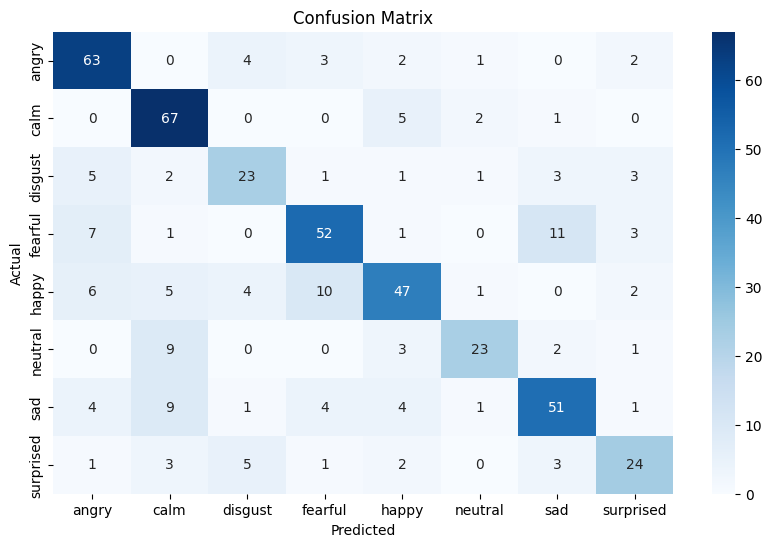

In [8]:
y_pred = model.predict(X_val)

# Overall Accuracy & F1
overall_accuracy = accuracy_score(y_val, y_pred)
overall_f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Weighted F1 Score: {overall_f1 * 100:.2f}%")

report = classification_report(y_val, y_pred, output_dict=True)

print("Per-Class Accuracies:")
for label in model.classes_:
    class_acc = report[label]["recall"] * 100
    print(f"{label}: {class_acc:.2f}% accuracy")


cm = confusion_matrix(y_val, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [9]:

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

In [10]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_enc)

y_pred_enc = xgb_model.predict(X_val)

C:\Users\viren\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:13:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [11]:
y_pred = le.inverse_transform(y_pred_enc)


XGBoost Accuracy: 73.52 %
XGBoost F1 Score: 73.14 %
Per-Class Accuracies:
  angry: 88.00%
  calm: 93.33%
  disgust: 58.97%
  fearful: 70.67%
  happy: 69.33%
  neutral: 68.42%
  sad: 62.67%
  surprised: 61.54%


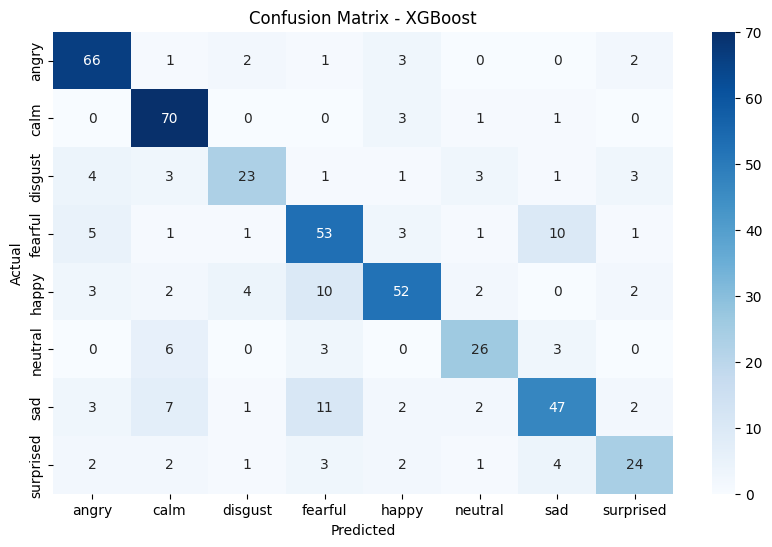

In [12]:
# Accuracy & F1
print("XGBoost Accuracy:", round(accuracy_score(y_val, y_pred) * 100, 2), "%")
print("XGBoost F1 Score:", round(f1_score(y_val, y_pred, average='weighted') * 100, 2), "%")

# Per-Class Accuracy
report = classification_report(y_val, y_pred, output_dict=True)
print("Per-Class Accuracies:")
for label in xgb_model.classes_:
    print(f"  {le.inverse_transform([label])[0]}: {report[le.inverse_transform([label])[0]]['recall']*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred, labels=le.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [13]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train_enc)

y_pred_enc = gb_model.predict(X_val)
y_pred = le.inverse_transform(y_pred_enc)

GB Accuracy: 61.3 %
GB F1 Score: 60.65 %
Per-Class Accuracies:
  angry: 77.33%
  calm: 82.67%
  disgust: 25.64%
  fearful: 61.33%
  happy: 53.33%
  neutral: 50.00%
  sad: 56.00%
  surprised: 61.54%


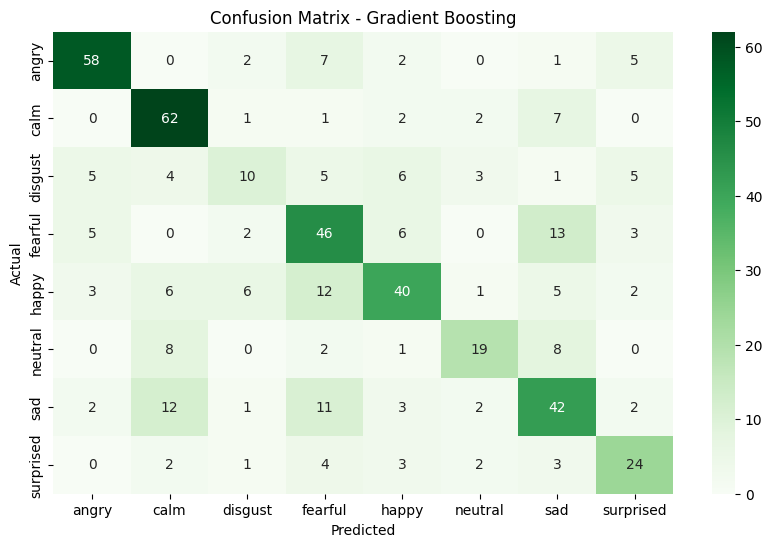

In [14]:
print("GB Accuracy:", round(accuracy_score(y_val, y_pred) * 100, 2), "%")
print("GB F1 Score:", round(f1_score(y_val, y_pred, average='weighted') * 100, 2), "%")

report = classification_report(y_val, y_pred, output_dict=True)
print("Per-Class Accuracies:")
for label in gb_model.classes_:
    print(f"  {le.inverse_transform([label])[0]}: {report[le.inverse_transform([label])[0]]['recall']*100:.2f}%")

cm = confusion_matrix(y_val, y_pred, labels=le.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

In [15]:
# Create a pipeline with scaling + SVM
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, random_state=42))

# Train
svm_model.fit(X_train, y_train_enc)

# Predict
y_pred_enc = svm_model.predict(X_val)
y_pred = le.inverse_transform(y_pred_enc)

SVM Accuracy: 67.62 %
SVM F1 Score: 67.2 %
Per-Class Accuracies:
  angry: 85.33%
  calm: 86.67%
  disgust: 53.85%
  fearful: 73.33%
  happy: 53.33%
  neutral: 50.00%
  sad: 56.00%
  surprised: 66.67%


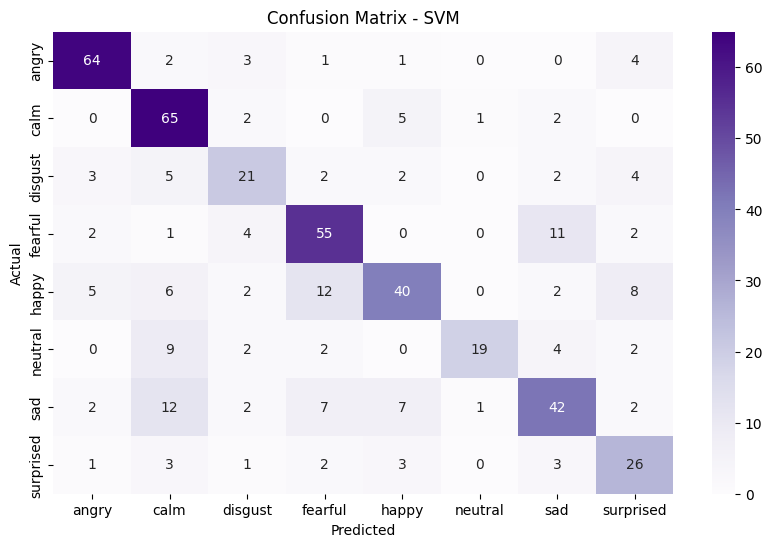

In [16]:
print("SVM Accuracy:", round(accuracy_score(y_val, y_pred) * 100, 2), "%")
print("SVM F1 Score:", round(f1_score(y_val, y_pred, average='weighted') * 100, 2), "%")

report = classification_report(y_val, y_pred, output_dict=True)
print("Per-Class Accuracies:")
for label in le.classes_:
    recall = report[label]["recall"] * 100
    print(f"  {label}: {recall:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred, labels=le.classes_)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Purples")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [17]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

In [18]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(xgb, param_grid, cv=3, n_jobs=-1, scoring='f1_weighted', verbose=1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\viren\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [15:14:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


Accuracy: 74.95 %
F1 Score: 74.65 %
Per-Class Accuracy:
  angry: 90.67%
  calm: 89.33%
  disgust: 58.97%
  fearful: 72.00%
  happy: 70.67%
  neutral: 68.42%
  sad: 66.67%
  surprised: 69.23%


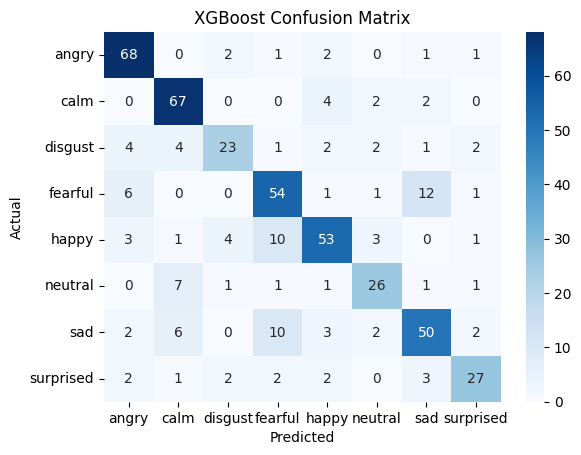

In [19]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_val)

print("Accuracy:", round(accuracy_score(y_val, y_pred)*100, 2), "%")
print("F1 Score:", round(f1_score(y_val, y_pred, average="weighted")*100, 2), "%")

print("Per-Class Accuracy:")
# Map class indices to names
report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)

for label in le.classes_:
    print(f"  {label}: {report[label]['recall']*100:.2f}%")


# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 40
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -2.550772
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -2.570575
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -2.550772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

📌 LightGBM Results:
✅ Accuracy: 74.13%
✅ Weighted F1 Score: 73.59%
🔎 Per-Class Accuracy:
  angry: 86.67%
  calm: 93.33%
  disgust: 53.85%
  fearful: 73.33%
  happy: 73.33%
  neutral: 65.79%
  sad: 72.00%

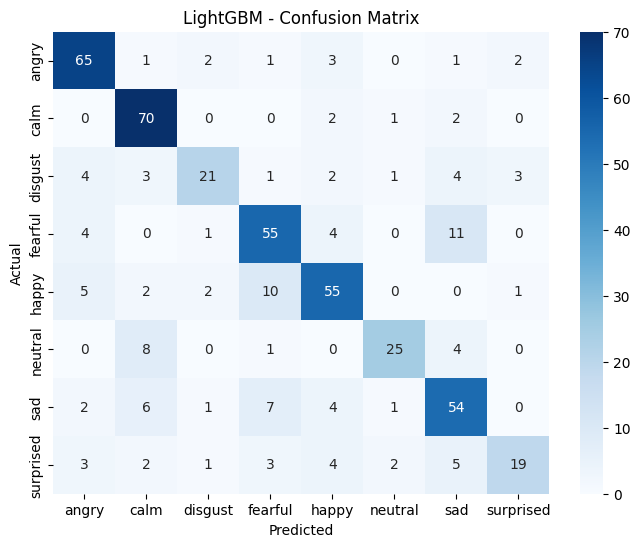


📌 CatBoost Results:
✅ Accuracy: 75.97%
✅ Weighted F1 Score: 75.72%
🔎 Per-Class Accuracy:
  angry: 88.00%
  calm: 90.67%
  disgust: 58.97%
  fearful: 72.00%
  happy: 68.00%
  neutral: 73.68%
  sad: 69.33%
  surprised: 79.49%


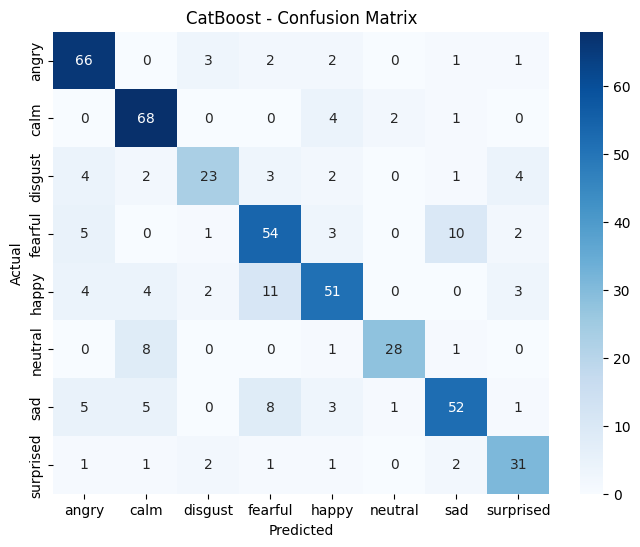


📌 Voting Ensemble (RF + XGB + LGBM) Results:
✅ Accuracy: 74.95%
✅ Weighted F1 Score: 74.56%
🔎 Per-Class Accuracy:
  angry: 86.67%
  calm: 94.67%
  disgust: 58.97%
  fearful: 74.67%
  happy: 73.33%
  neutral: 65.79%
  sad: 66.67%
  surprised: 58.97%


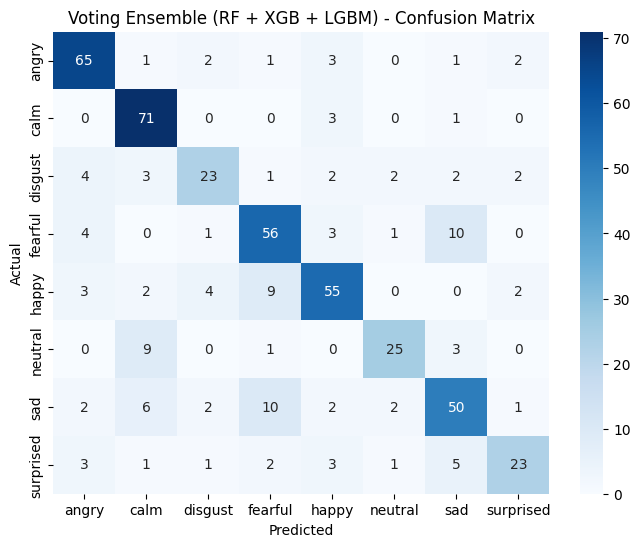

In [20]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# === Function to Evaluate Model ===
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')

    print(f"\n📌 {name} Results:")
    print(f"✅ Accuracy: {acc*100:.2f}%")
    print(f"✅ Weighted F1 Score: {f1*100:.2f}%")

    # Classification Report
    report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)

    print("🔎 Per-Class Accuracy:")
    for label in le.classes_:
        recall = report[label]['recall']
        print(f"  {label}: {recall*100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# === 1. LightGBM ===
lgbm = LGBMClassifier(random_state=42)
evaluate_model(lgbm, "LightGBM")

# === 2. CatBoost ===
catboost = CatBoostClassifier(verbose=0, random_state=42)
evaluate_model(catboost, "CatBoost")

# === 3. Ensemble (XGB + RF + LGBM) ===
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
], voting='soft', n_jobs=-1)

evaluate_model(ensemble, "Voting Ensemble (RF + XGB + LGBM)")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
📌 CatBoost Best Params: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
✅ Accuracy: 67.01 %
✅ F1 Score: 66.5 %
🔎 Per-Class Accuracy:
  angry: 80.00%
  calm: 90.67%
  disgust: 53.85%
  fearful: 66.67%
  happy: 57.33%
  neutral: 50.00%
  sad: 57.33%
  surprised: 64.10%


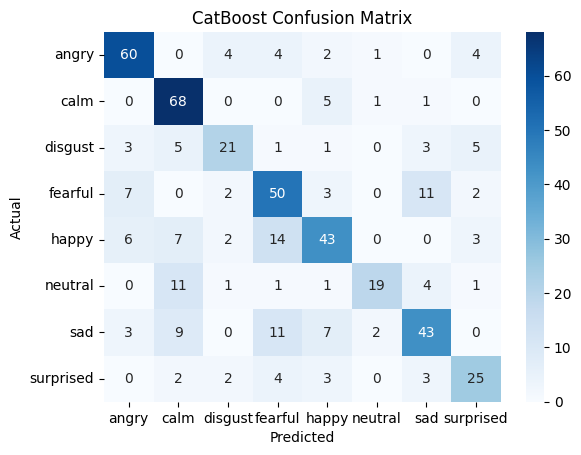

In [21]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

cat_params = {
    'iterations': [200, 300],
    'depth': [4, 6],
    'learning_rate': [0.03, 0.05],
    'l2_leaf_reg': [1, 3]
}

cat_model = CatBoostClassifier(verbose=0, random_state=42)
skf = StratifiedKFold(n_splits=3)
cat_grid = GridSearchCV(cat_model, cat_params, cv=skf, scoring='f1_weighted', n_jobs=-1, verbose=1)
cat_grid.fit(X_train, y_train)

best_cat = cat_grid.best_estimator_
y_pred_cat = best_cat.predict(X_val)

print("📌 CatBoost Best Params:", cat_grid.best_params_)
print("✅ Accuracy:", round(accuracy_score(y_val, y_pred_cat)*100, 2), "%")
print("✅ F1 Score:", round(f1_score(y_val, y_pred_cat, average='weighted')*100, 2), "%")

report_cat = classification_report(y_val, y_pred_cat, target_names=le.classes_, output_dict=True)

print("🔎 Per-Class Accuracy:")
for label in le.classes_:
    print(f"  {label}: {report_cat[label]['recall']*100:.2f}%")

cm_cat = confusion_matrix(y_val, y_pred_cat)
sns.heatmap(cm_cat, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("CatBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 40
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -2.550772
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -2.570575
[LightGBM] [Info] Start training from score -1.874100
[LightGBM] [Info] Start training from score -2.550772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

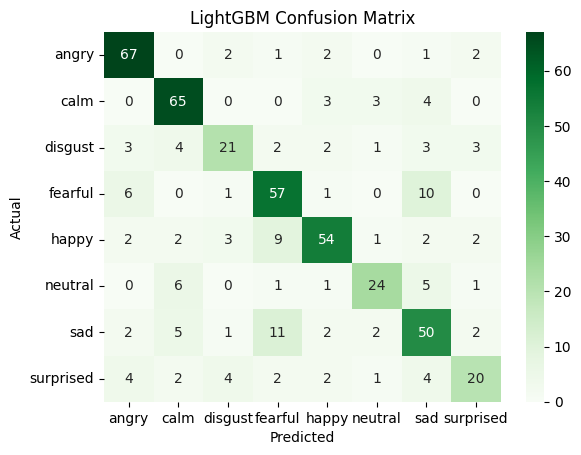

In [22]:
from lightgbm import LGBMClassifier

lgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.8, 1]
}

lgb_model = LGBMClassifier(random_state=42)
skf = StratifiedKFold(n_splits=3)
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=skf, scoring='f1_weighted', n_jobs=-1, verbose=1)
lgb_grid.fit(X_train, y_train)

best_lgb = lgb_grid.best_estimator_
y_pred_lgb = best_lgb.predict(X_val)

print("📌 LightGBM Best Params:", lgb_grid.best_params_)
print("✅ Accuracy:", round(accuracy_score(y_val, y_pred_lgb)*100, 2), "%")
print("✅ F1 Score:", round(f1_score(y_val, y_pred_lgb, average='weighted')*100, 2), "%")

report_lgb = classification_report(y_val, y_pred_lgb, target_names=le.classes_, output_dict=True)

print("🔎 Per-Class Accuracy:")
for label in le.classes_:
    print(f"  {label}: {report_lgb[label]['recall']*100:.2f}%")

cm_lgb = confusion_matrix(y_val, y_pred_lgb)
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Greens", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Class weights: {np.int64(0): np.float64(0.8151595744680851), np.int64(1): np.float64(0.8151595744680851), np.int64(2): np.float64(1.5963541666666667), np.int64(3): np.float64(0.8151595744680851), np.int64(4): np.float64(0.8151595744680851), np.int64(5): np.float64(1.6303191489361701), np.int64(6): np.float64(0.8151595744680851), np.int64(7): np.float64(1.5963541666666667)}
✅ Accuracy: 71.28%
✅ Weighted F1 Score: 70.97%
🔎 Per-Class Accuracy:
  angry: 84.00%
  calm: 86.67%
  disgust: 66.67%
  fearful: 66.67%
  happy: 57.33%
  neutral: 76.32%
  sad: 57.33%
  surprised: 79.49%


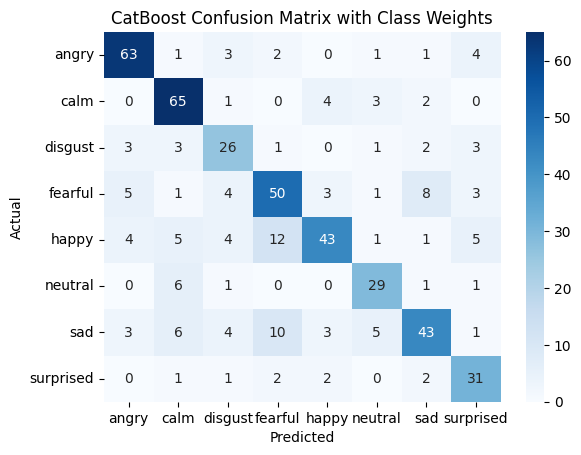

In [23]:
# STEP 1: Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(df["label"])
X = df.drop("label", axis=1)

# STEP 2: Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# STEP 3: Calculate class weights
classes = np.unique(y_enc)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_enc)
weights_dict = dict(zip(classes, class_weights))

print("Class weights:", weights_dict)

# STEP 4: Train CatBoost with class weights
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    class_weights=weights_dict,
    random_state=42,
    verbose=0
)
catboost_model.fit(X_train, y_train)

# STEP 5: Evaluate
y_pred = catboost_model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average="weighted")
print(f"✅ Accuracy: {acc*100:.2f}%")
print(f"✅ Weighted F1 Score: {f1*100:.2f}%")

# Classification Report
report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)
print("🔎 Per-Class Accuracy:")
for label in le.classes_:
    print(f"  {label}: {report[label]['recall']*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("CatBoost Confusion Matrix with Class Weights")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

✅ Accuracy: 54.58%
✅ Weighted F1 Score: 53.96%
🔎 Per-Class Accuracy:
  angry: 72.00%
  calm: 26.67%
  disgust: 69.23%
  fearful: 56.00%
  happy: 42.67%
  neutral: 55.26%
  sad: 66.67%
  surprised: 56.41%


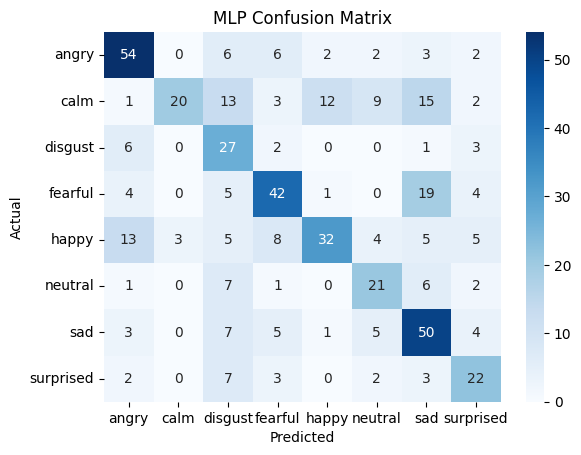

In [24]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(df["label"])
X = df.drop("label", axis=1)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# MLP Model
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    max_iter=500,
    activation='relu',
    solver='adam',
    random_state=42
)
mlp.fit(X_train, y_train)

# Predict & Evaluate
y_pred = mlp.predict(X_val)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"✅ Accuracy: {acc*100:.2f}%")
print(f"✅ Weighted F1 Score: {f1*100:.2f}%")

report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)
print("🔎 Per-Class Accuracy:")
for label in le.classes_:
    print(f"  {label}: {report[label]['recall']*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

✅ Accuracy: 74.95%
✅ Weighted F1 Score: 74.63%
🔎 Per-Class Accuracy:
  angry: 86.67%
  calm: 93.33%
  disgust: 58.97%
  fearful: 73.33%
  happy: 73.33%
  neutral: 68.42%
  sad: 66.67%
  surprised: 61.54%


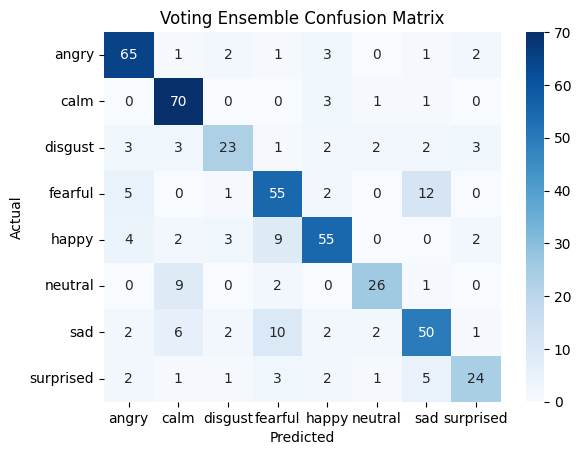

In [25]:
# Step 1: Encode Labels
le = LabelEncoder()
y_enc = le.fit_transform(df["label"])
X = df.drop("label", axis=1)

# Step 2: Split Data
X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

# Step 3: Define Base Models
cat_model = CatBoostClassifier(verbose=0, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm_model = LGBMClassifier(random_state=42)

# Step 4: Soft Voting Ensemble
ensemble = VotingClassifier(
    estimators=[
        ('catboost', cat_model),
        ('xgboost', xgb_model),
        ('lightgbm', lgbm_model)
    ],
    voting='soft',  # Use predicted probabilities
    n_jobs=-1
)

# Step 5: Train
ensemble.fit(X_train, y_train)

# Step 6: Predict and Evaluate
y_pred = ensemble.predict(X_val)

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"✅ Accuracy: {acc * 100:.2f}%")
print(f"✅ Weighted F1 Score: {f1 * 100:.2f}%")

report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)
print("🔎 Per-Class Accuracy:")
for label in le.classes_:
    print(f"  {label}: {report[label]['recall']*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Voting Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

✅ Accuracy: 74.75%
✅ Weighted F1 Score: 74.46%
🔎 Per-Class Accuracy:
  angry: 86.67%
  calm: 90.67%
  disgust: 56.41%
  fearful: 68.00%
  happy: 66.67%
  neutral: 81.58%
  sad: 66.67%
  surprised: 76.92%


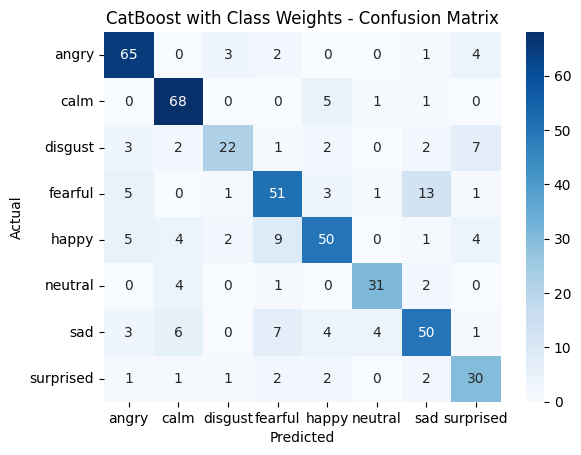

In [26]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(df["label"])
X = df.drop("label", axis=1)

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

# Class weights
counts = Counter(y_train)
total = sum(counts.values())
class_weights = {cls: total / count for cls, count in counts.items()}
weights_list = [class_weights[y] for y in y_train]

# Train CatBoost with class weights
train_pool = Pool(X_train, y_train, weight=weights_list)
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(train_pool)

# Predict
y_pred = model.predict(X_val)

# Evaluation
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average="weighted")
report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)

print(f"✅ Accuracy: {acc * 100:.2f}%")
print(f"✅ Weighted F1 Score: {f1 * 100:.2f}%")
print("🔎 Per-Class Accuracy:")
for label in le.classes_:
    print(f"  {label}: {report[label]['recall']*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("CatBoost with Class Weights - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



0:	learn: 2.0641654	total: 95.3ms	remaining: 38s
100:	learn: 1.2985183	total: 10.6s	remaining: 31.2s
200:	learn: 0.9535913	total: 20.4s	remaining: 20.2s
300:	learn: 0.7240317	total: 30.2s	remaining: 9.92s
399:	learn: 0.5635545	total: 40.3s	remaining: 0us
✅ Accuracy: 63.54%
✅ Weighted F1 Score: 63.43%
🔎 Per-Class Accuracy:
  angry: 74.67%
  calm: 81.33%
  disgust: 64.10%
  fearful: 54.67%
  happy: 45.33%
  neutral: 65.79%
  sad: 52.00%
  surprised: 79.49%


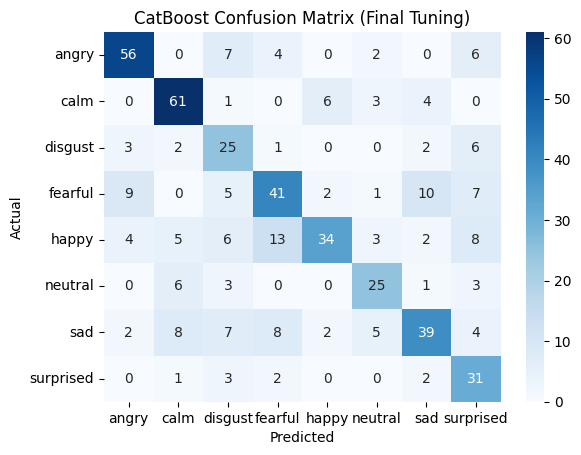

In [27]:
# Label encoding
le = LabelEncoder()
y = le.fit_transform(df["label"])
X = df.drop("label", axis=1)

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Class weights manually
counts = Counter(y_train)
total = sum(counts.values())
class_weights = {cls: total/count for cls, count in counts.items()}
weights = [class_weights[i] for i in y_train]

# Prepare Pool
train_pool = Pool(X_train, y_train, weight=weights)
val_pool = Pool(X_val, y_val)

# Final CatBoost with tuned parameters
model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.03,
    depth=8,
    loss_function="MultiClass",
    random_state=42,
    verbose=100
)
model.fit(train_pool)

# Predict
y_pred = model.predict(val_pool)
y_pred = y_pred.flatten()  # Ensure 1D

# Evaluate
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average="weighted")
report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)

print(f"✅ Accuracy: {acc*100:.2f}%")
print(f"✅ Weighted F1 Score: {f1*100:.2f}%")
print("🔎 Per-Class Accuracy:")
for label in le.classes_:
    print(f"  {label}: {report[label]['recall']*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CatBoost Confusion Matrix (Final Tuning)")
plt.show()


0:	learn: 0.3437022	test: 0.2973523	best: 0.2973523 (0)	total: 22.3ms	remaining: 22.2s
100:	learn: 0.7419684	test: 0.5458248	best: 0.5458248 (100)	total: 1.93s	remaining: 17.2s
200:	learn: 0.8567058	test: 0.6028513	best: 0.6028513 (200)	total: 3.93s	remaining: 15.6s
300:	learn: 0.9331973	test: 0.6374745	best: 0.6476578 (290)	total: 5.92s	remaining: 13.7s
400:	learn: 0.9632840	test: 0.6558045	best: 0.6598778 (374)	total: 7.91s	remaining: 11.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6598778004
bestIteration = 374

Shrink model to first 375 iterations.
✅ Accuracy: 65.99%
✅ Weighted F1 Score: 65.60%
🔎 Per-Class Accuracy:
  0: 82.67%
  1: 82.67%
  2: 53.85%
  3: 65.33%
  4: 56.00%
  5: 52.63%
  6: 57.33%
  7: 64.10%


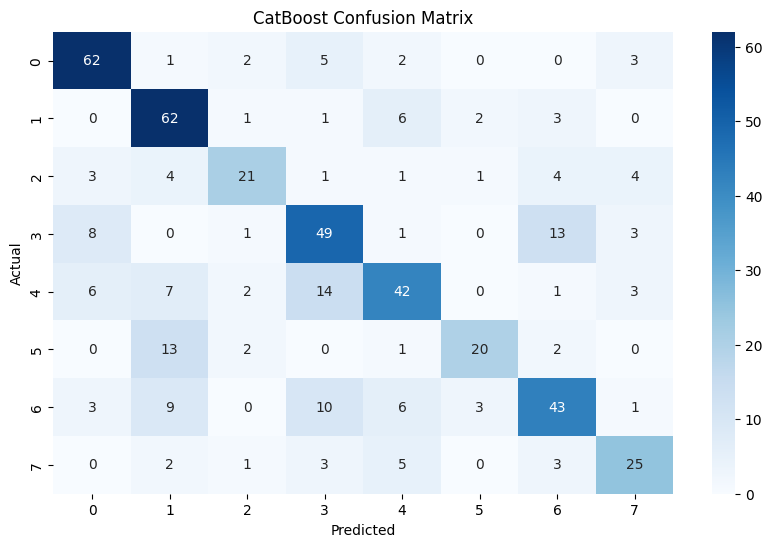

In [28]:
# Label encoding
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

# Define CatBoost pool
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

# Train CatBoost with early stopping
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
)

model.fit(train_pool, eval_set=val_pool, use_best_model=True)

# Predict
y_pred = model.predict(X_val).flatten()

# Evaluate
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"✅ Accuracy: {acc * 100:.2f}%")
print(f"✅ Weighted F1 Score: {f1 * 100:.2f}%")

# Classification Report
report = classification_report(y_val, y_pred, target_names=le.classes_, output_dict=True)
print("🔎 Per-Class Accuracy:")
for label in le.classes_:
    print(f"  {label}: {report[label]['recall'] * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("CatBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()